Dataset Overview:
      Unnamed   X1   X2   X3   X4   X5   X6   X7   X8   X9  ...  X170  X171  \
0  X21.V1.791  135  190  229  223  192  125   55   -9  -33  ...   -17   -15   
1  X15.V1.924  386  382  356  331  320  315  307  272  244  ...   164   150   
2     X8.V1.1  -32  -39  -47  -37  -32  -36  -57  -73  -85  ...    57    64   
3   X16.V1.60 -105 -101  -96  -92  -89  -95 -102 -100  -87  ...   -82   -81   
4   X20.V1.54   -9  -65  -98 -102  -78  -48  -16    0  -21  ...     4     2   

   X172  X173  X174  X175  X176  X177  X178  y  
0   -31   -77  -103  -127  -116   -83   -51  4  
1   146   152   157   156   154   143   129  1  
2    48    19   -12   -30   -35   -35   -36  5  
3   -80   -77   -85   -77   -72   -69   -65  5  
4   -12   -32   -41   -65   -83   -89   -73  5  

[5 rows x 180 columns]

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11500 entries, 0 to 11499
Columns: 180 entries, Unnamed to y
dtypes: int64(179), object(1)
memory usage: 15.8+ MB
Non

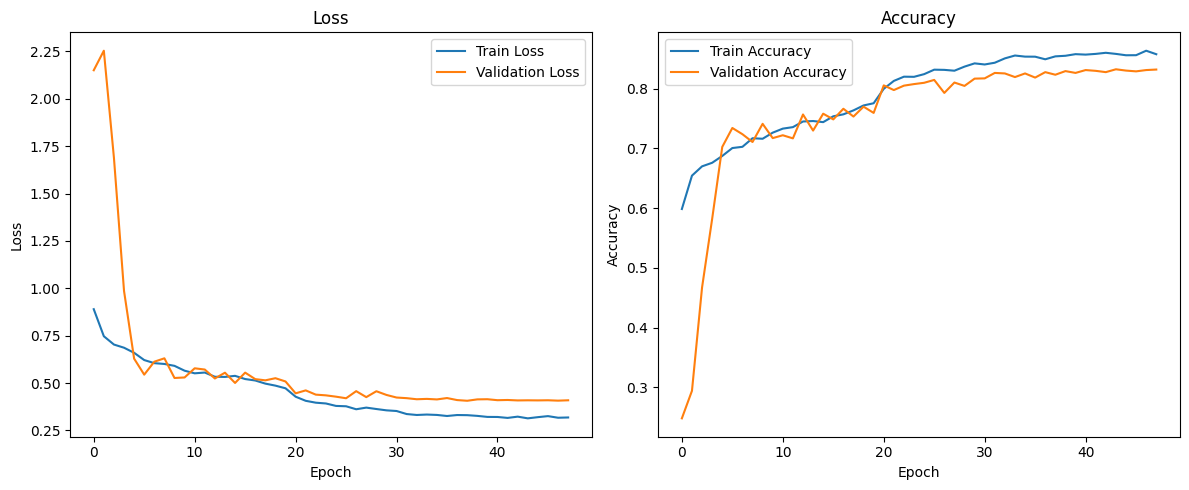

<ipython-input-4-420d4608bfd9>:132: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


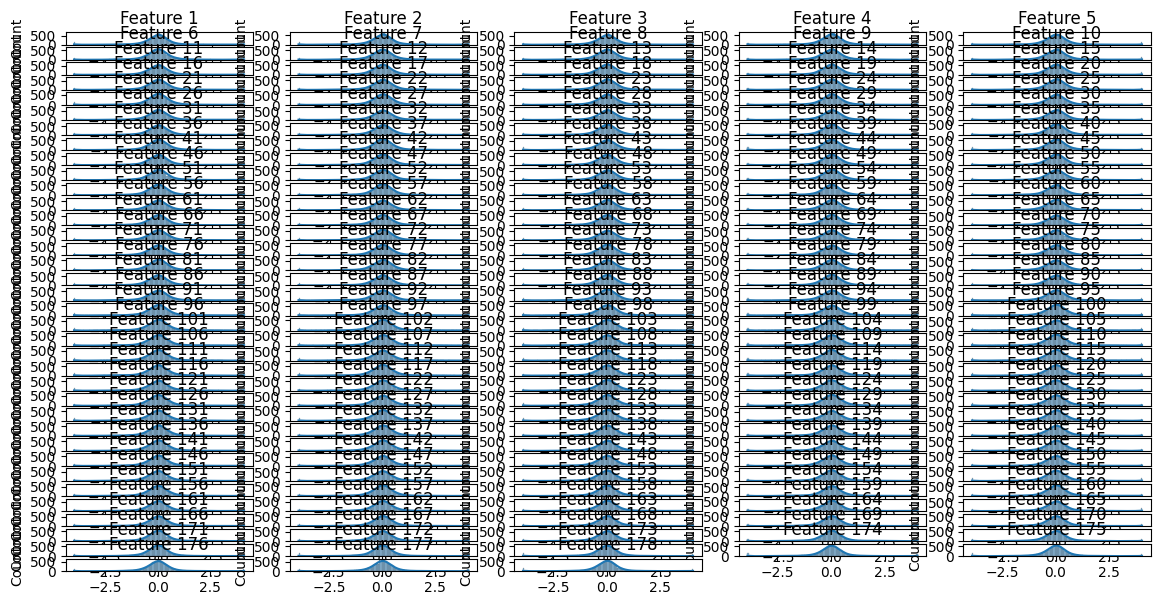

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Bidirectional, LSTM, AveragePooling1D, Dropout, Flatten, Dense, Attention, Concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Load the dataset
data = pd.read_csv('/content/Epileptic Seizure Recognition.csv')

# Dataset details
print("Dataset Overview:")
print(data.head())
print("\nDataset Information:")
print(data.info())
print("\nDataset Statistics:")
print(data.describe())
print("\nLabel Distribution:")
print(data.iloc[:, -1].value_counts())

# Separate features and labels
X = data.iloc[:, :-1]  # Features
y = data.iloc[:, -1].values  # Labels

# Ensure all columns in X are numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Drop columns with any NaN values (resulting from non-numeric conversions)
X = X.dropna(axis=1)

# Convert to numpy array after processing
X = X.values

# Preprocessing
# 1. Handling potential outliers by clipping the values
X = np.clip(X, np.percentile(X, 1), np.percentile(X, 99))

# 2. Normalize the data using StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 3. Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y)  # One-hot encoding

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape input for CNN
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Functional API Model
inputs = Input(shape=(X_train.shape[1], 1))

# Multiple 1D Convolutional Layers with Batch Normalization and Dropout
x = Conv1D(filters=128, kernel_size=5, activation='relu')(inputs)
x = BatchNormalization()(x)
x = AveragePooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
x = BatchNormalization()(x)
x = AveragePooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

# Bidirectional LSTM Layer
lstm_out = Bidirectional(LSTM(100, return_sequences=True))(x)
lstm_out = Dropout(0.3)(lstm_out)

# Attention Layer
query = Dense(100)(lstm_out)
value = Dense(100)(lstm_out)
attention_out = Attention()([query, value])

# Flatten and Dense Layers
x = Flatten()(attention_out)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(y.shape[1], activation='softmax')(x)  # Output layer

# Create and compile the model
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for learning rate reduction and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model and store history
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[reduce_lr, early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy * 100:.2f}%')

# Data Visualization

# Plot training & validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Visualize feature distributions
plt.figure(figsize=(14, 7))
for i in range(X.shape[1]):
    plt.subplot((X.shape[1] // 5) + 1, 5, i + 1)
    sns.histplot(X[:, i], kde=True)
    plt.title(f'Feature {i + 1}')
plt.tight_layout()
plt.show()